### Installing necessary modules

In [30]:
%pip install librosa
%pip install numpy
%pip install pandas
%pip install tensorflow
%pip install scipy
%pip install sklearn
%pip install matplotlib
%pip install keras


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


### Importing the required libraries

In [31]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import scipy.io.wavfile
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, Dropout, Activation, Conv1D, MaxPooling1D, AveragePooling1D, Dense, Embedding, LSTM
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import sys

In [32]:
datasetInstance = 1200 # 0 to 1439
dataset= os.listdir('dataset/')
print(dataset[datasetInstance]) 
print(dataset[datasetInstance][6:8])

03-01-07-02-02-01-02.wav
07


### Plotting the audio file's waveform and its spectrogram

In [33]:
data, sampleRate = librosa.load(f"dataset/{dataset[datasetInstance]}")

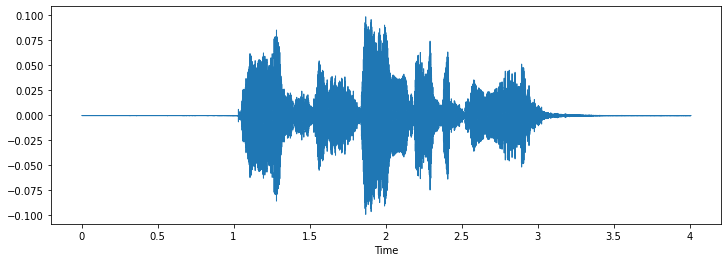

In [34]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampleRate)

<ipython-input-35-6ab8411289ea>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, wavData = scipy.io.wavfile.read(f"dataset/{dataset[datasetInstance]}")
<ipython-input-35-6ab8411289ea>:13: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nWindow//2]))


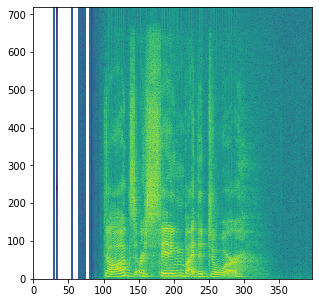

In [35]:
sampleRate, wavData = scipy.io.wavfile.read(f"dataset/{dataset[datasetInstance]}")

nStep = int(sampleRate * 0.01)
nWindow = int(sampleRate * 0.03)
window = np.hamming(nWindow)
nn = range(nWindow, len(wavData), nStep)

X = np.zeros((len(nn), nWindow//2))

for i,n in enumerate(nn):
    xSeg = wavData[n-nWindow:n]
    z = np.fft.fft(window * xSeg, nWindow)
    X[i,:] = np.log(np.abs(z[:nWindow//2]))
plt.figure(figsize = (5,5))
plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')

### Setting the labels

In [36]:
Emotions=[]
emotionDict = {"02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

for file in dataset:
    em = file[6:8]
    if em in emotionDict:
        Emotions.append(("male_" if int(file[18:20])%2 else "female_") + emotionDict[em])

In [37]:
labels = pd.DataFrame(Emotions)
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


### Getting the features of audio files using librosa

In [38]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index, y in enumerate(dataset):
    if dataset[index][6:8] not in ["01", "07", "08"]:
        X, sampleRate = librosa.load('dataset/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sampleRate = np.array(sampleRate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=13), axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark+=1        

In [39]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.99512, -61.87015, -67.49628, -..."


In [40]:
df3 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})

df3[:5]

In [41]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792603,-40.614010,-41.209984,-41.439613,-43.994671,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119911,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674789,-48.596626,-47.603226,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995121,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-39.072914,-41.896793,-40.866917,-38.293266,-36.375122,-37.914906,-40.027390,-43.315861,-44.848812,male_calm


In [42]:
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
793,-58.972652,-58.049759,-58.151329,-57.871483,-58.174553,-57.711205,-57.611122,-58.106079,-58.613579,-58.103130,...,-55.683369,-53.569553,-53.667385,-54.336613,-54.403111,-54.941219,-53.644165,-52.814964,-53.177284,female_fearful
60,-50.159523,-53.069500,-57.424614,-60.286369,-63.514866,-59.823421,-59.656052,-60.265438,-60.922611,-63.632805,...,-66.580559,-65.908928,-65.688370,-59.147831,-57.583408,-60.386532,-62.520874,-63.577370,-65.219269,male_calm
629,-54.448387,-54.199749,-54.582302,-55.394207,-53.599491,-52.998283,-53.848434,-51.619289,-52.170609,-53.926395,...,-41.699074,-40.542038,-40.743080,-40.040100,-40.254978,-40.493328,-41.870708,-37.284637,-30.505573,female_angry
854,-54.885944,-57.135864,-59.190350,-58.815002,-59.682644,-60.168266,-60.022163,-59.729866,-59.597206,-59.301842,...,-48.448460,-48.096260,-48.527767,-49.944275,-50.918350,-51.535423,-52.271572,-52.280884,-50.547264,male_fearful
464,-71.806488,-66.335724,-66.995544,-64.951683,-58.959187,-58.266018,-62.301853,-57.438602,-54.119785,-52.604141,...,-54.921349,-57.776428,-60.300983,-60.116390,-58.886379,-59.478825,-63.491470,-64.425446,-64.874657,male_sad
746,-44.503330,-44.689327,-44.712387,-44.634670,-44.523594,-44.407631,-44.553719,-44.552387,-44.371010,-44.258205,...,-14.018621,-13.313854,-11.888726,-10.064295,-8.501783,-10.812926,-12.970713,-12.086283,-9.885050,male_angry
613,-57.463684,-57.463684,-57.463684,-57.463684,-57.463684,-57.463684,-57.463684,-57.463684,-57.463684,-57.463684,...,-54.851383,-53.277225,-50.585182,-52.077427,-55.145195,-54.182758,-54.183670,-52.518974,-48.851051,female_angry
471,-63.442863,-63.442863,-63.442863,-63.442863,-63.442863,-63.442863,-63.442863,-63.442863,-63.442863,-63.442863,...,-59.520451,-59.307293,-58.755886,-59.800346,-58.920662,-60.878609,-62.100407,-60.307091,-60.436157,female_sad
736,-46.232143,-46.328865,-47.998714,-48.546097,-48.741009,-48.696697,-49.223675,-49.937992,-48.969791,-47.325920,...,-45.053066,-45.692543,-44.578453,-45.991203,-44.805992,-43.478352,-44.344181,-45.437485,-44.582375,male_angry
25,-65.278252,-65.278252,-65.278252,-65.278252,-65.278252,-65.278252,-65.278252,-65.278252,-65.278252,-65.278252,...,-35.932846,-36.282341,-37.473484,-37.166897,-36.922752,-36.211388,-36.734085,-38.822945,-39.712666,female_calm


### Dividing the data into test and train

In [43]:
rnewdf=rnewdf.fillna(0)
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [44]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
406,-68.674202,-68.674202,-68.674202,-68.674202,-68.674202,-68.674202,-68.674202,-68.674202,-68.674202,-68.674202,...,-63.509579,-59.659512,-57.811848,-60.131226,-65.151367,-68.674202,-66.287552,-66.480721,-68.674202,male_sad
465,-54.690247,-52.580315,-52.750557,-52.834370,-53.975220,-55.492302,-53.619743,-51.268818,-49.406441,-48.820450,...,-44.090981,-43.910744,-43.877316,-45.999077,-47.510735,-47.583755,-50.065411,-48.573215,-52.198444,female_sad
676,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-42.741909,-42.918076,-43.103676,-43.103676,...,-43.078342,-43.103676,-43.103676,-43.103676,-43.103676,-42.908737,-43.103676,-43.103676,-43.103676,male_angry
510,-59.121243,-57.836197,-58.504597,-59.658840,-59.949509,-59.686256,-57.400024,-57.776875,-57.546780,-59.210350,...,-37.874241,-37.111179,-33.075718,-30.842722,-29.883614,-29.688337,-30.495607,-30.616493,-28.900112,male_sad
451,-79.090874,-79.090874,-79.090874,-79.090874,-79.090874,-79.090874,-79.090874,-79.090874,-79.090874,-79.090874,...,-63.005371,-67.965233,-66.265732,-63.627316,-64.210571,-68.124374,-66.042847,-65.636520,-72.073509,female_sad
125,-71.368393,-69.982140,-71.188110,-70.811699,-69.813934,-69.617386,-68.460442,-70.130150,-72.018425,-72.018425,...,-45.057518,-45.751999,-44.786079,-43.501358,-44.520500,-44.736923,-45.162144,-44.141270,-41.520939,female_calm
47,-71.407524,-71.407524,-71.407524,-71.407524,-71.407524,-71.407524,-71.407524,-71.407524,-71.407524,-71.407524,...,-64.322197,-66.922920,-70.592232,-69.531288,-66.970428,-66.873825,-68.084854,-70.434067,-71.113396,female_calm
117,-62.938194,-60.485619,-56.191677,-51.479763,-46.884861,-45.836216,-49.037231,-51.724384,-50.980553,-52.645428,...,-48.214695,-46.509895,-47.161781,-48.837482,-50.407066,-53.549622,-57.054409,-56.367470,-57.108906,female_calm
341,-43.115608,-44.846779,-44.720066,-45.233704,-46.389500,-46.609821,-46.289070,-45.192062,-45.330986,-45.296104,...,-42.721375,-43.540249,-43.351967,-43.273075,-43.244930,-44.006538,-44.455894,-40.090736,-34.977428,female_happy
150,-63.240623,-61.394390,-62.446720,-64.448654,-66.765305,-67.362152,-67.470222,-66.983162,-66.916061,-67.387474,...,-31.940809,-33.437809,-32.755821,-32.911129,-33.727619,-33.295853,-32.799961,-30.818869,-28.732069,male_calm


In [45]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [46]:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


c:\Users\rsama\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
print(X_train.shape, y_train.shape)

(748, 216) (748, 10)


### Changing dimension for CNN model

In [48]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_traincnn.shape, x_testcnn.shape)

(748, 216, 1) (212, 216, 1)


In [49]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1536      
                                                                 
 activation_5 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_6 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [51]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# print(x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape)

### Removed the whole training part for avoiding unnecessary long epochs list

In [168]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
71/71 [==============================] - 2s 34ms/step - loss: 0.6461 - accuracy: 0.7278 - val_loss: 3.1086 - val_accuracy: 0.2975
Epoch 2/700
71/71 [==============================] - 2s 32ms/step - loss: 0.6611 - accuracy: 0.7082 - val_loss: 2.9919 - val_accuracy: 0.2785
Epoch 3/700
71/71 [==============================] - 2s 33ms/step - loss: 0.6569 - accuracy: 0.7224 - val_loss: 3.0365 - val_accuracy: 0.2911
Epoch 4/700
71/71 [==============================] - 2s 34ms/step - loss: 0.6527 - accuracy: 0.7162 - val_loss: 2.9594 - val_accuracy: 0.2753
Epoch 5/700
71/71 [==============================] - 2s 33ms/step - loss: 0.6535 - accuracy: 0.7171 - val_loss: 2.9704 - val_accuracy: 0.2722
Epoch 6/700
71/71 [==============================] - 2s 34ms/step - loss: 0.6618 - accuracy: 0.7082 - val_loss: 2.9534 - val_accuracy: 0.2690
Epoch 7/700
71/71 [==============================] - 2s 33ms/step - loss: 0.6526 - accuracy: 0.7135 - val_loss: 3.0972 - val_accuracy: 0.3006
Epoch 

In [22]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'cnnhistory' is not defined

## Saving the model

In [171]:
model_name = 'Emotion_Voice_Detection_Model2.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\rsama\OneDrive\Desktop\Codey\misc\Emotion Detector Using Voice as an Input\saved_models\Emotion_Voice_Detection_Model.h5 


In [23]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [63]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 88.21%


## Predicting emotions on the test data

In [64]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

7/7 [==============================] - 0s 12ms/step


In [65]:
preds

array([[1.56338057e-20, 4.26737977e-14, 2.61001607e-25, ...,
        2.75277645e-09, 1.34971234e-08, 9.99667525e-01],
       [2.15792648e-10, 6.49162674e-30, 2.90755115e-12, ...,
        2.69960765e-07, 3.81024256e-05, 4.89223851e-07],
       [4.09184188e-12, 1.65955253e-28, 3.79250639e-24, ...,
        2.52657799e-07, 3.89260931e-05, 1.86978923e-06],
       ...,
       [6.92438240e-09, 1.01260857e-08, 3.21822658e-17, ...,
        3.40578254e-06, 1.01101159e-06, 1.05267136e-04],
       [2.69036759e-02, 4.77894282e-05, 4.65387202e-05, ...,
        4.59591178e-07, 7.07685063e-03, 9.64064777e-01],
       [2.11989777e-06, 1.53185364e-12, 1.00671312e-11, ...,
        9.80899096e-01, 7.34269293e-03, 4.96842331e-05]], dtype=float32)

In [66]:
preds1=preds.argmax(axis=1)
preds1

array([9, 5, 5, 1, 8, 7, 9, 1, 1, 7, 3, 8, 5, 8, 8, 1, 3, 3, 3, 6, 8, 9,
       3, 6, 2, 7, 4, 8, 4, 3, 5, 5, 0, 1, 9, 4, 5, 7, 5, 6, 7, 6, 7, 9,
       6, 3, 8, 9, 2, 4, 1, 6, 8, 7, 9, 8, 9, 6, 6, 8, 8, 7, 9, 4, 9, 0,
       4, 0, 1, 3, 9, 6, 9, 8, 5, 4, 6, 4, 1, 3, 9, 2, 8, 2, 7, 9, 0, 6,
       7, 3, 1, 1, 0, 1, 2, 2, 6, 8, 2, 9, 0, 9, 8, 4, 1, 1, 4, 4, 3, 3,
       8, 1, 2, 4, 1, 7, 8, 1, 3, 0, 4, 1, 9, 5, 8, 4, 1, 6, 8, 1, 2, 3,
       6, 2, 6, 4, 9, 1, 0, 8, 9, 9, 3, 4, 7, 7, 2, 6, 1, 0, 8, 5, 0, 4,
       2, 9, 1, 1, 4, 3, 5, 0, 1, 0, 3, 7, 7, 6, 1, 6, 9, 4, 8, 2, 1, 4,
       0, 0, 6, 1, 8, 9, 5, 5, 6, 6, 8, 5, 1, 4, 0, 2, 5, 2, 8, 5, 6, 4,
       0, 8, 5, 0, 0, 4, 8, 1, 6, 2, 6, 6, 9, 7], dtype=int64)

In [67]:
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_sad
1,male_angry
2,male_angry
3,female_calm
4,male_happy
5,male_fearful
6,male_sad
7,female_calm
8,female_calm
9,male_fearful


In [68]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [69]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_sad
1,male_angry
2,male_angry
3,female_calm
4,male_happy
5,male_fearful
6,male_sad
7,female_calm
8,female_calm
9,male_fearful


In [70]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [71]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_sad,female_sad
172,male_happy,male_happy
173,female_fearful,female_fearful
174,female_calm,female_calm
175,female_sad,female_sad
176,female_angry,female_angry
177,female_sad,female_angry
178,male_calm,male_calm
179,female_calm,female_calm


In [72]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,15
female_calm,27
female_fearful,16
female_happy,22
female_sad,23
male_angry,19
male_calm,26
male_fearful,18
male_happy,24


In [73]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,18
female_calm,29
female_fearful,16
female_happy,17
female_sad,23
male_angry,17
male_calm,25
male_fearful,16
male_happy,27


In [74]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'outputXX.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [75]:
data, sampleRate = librosa.load('output13.wav')

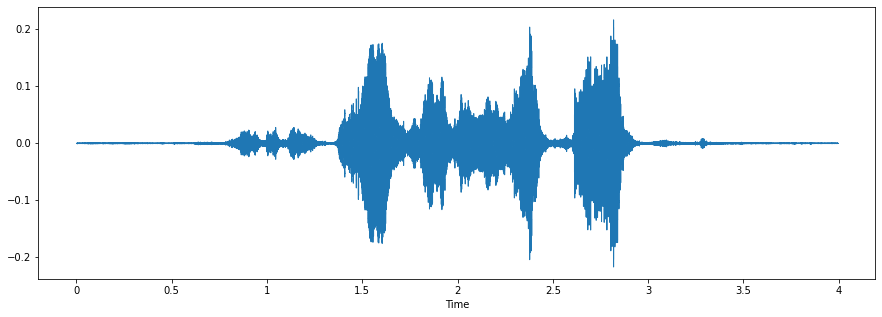

In [76]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampleRate)

In [78]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output13.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [79]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-40.377232,-37.452095,-40.084312,-43.502048,-43.934589,-43.675255,-44.321983,-46.459648,-46.218693,-45.294407,...,-32.194424,-33.598942,-33.634819,-36.638103,-38.195816,-36.304951,-35.62529,-34.84993,-34.74514,-36.412193


In [80]:
twodim= np.expand_dims(livedf2, axis=2)

In [81]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 17ms/step


In [82]:
livepreds

array([[5.6838540e-05, 5.3854007e-01, 4.6278228e-04, 4.4863960e-01,
        1.2270242e-02, 2.5268009e-14, 1.0288904e-09, 2.9737148e-05,
        1.9028803e-08, 7.7701588e-07]], dtype=float32)

In [83]:
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))

print("The predicted gender is '{}' and the emotion is '{}'.".format(*livepredictions[0].split("_")))

The predicted gender is 'female' and the emotion is 'calm'.
